# Executable example of how to run ECToNAS

## Copyright (c) 2022 Schiessler et al.

Note that running this file will download a large amount of data. Running ECToNAS will potentially require a large amount of computational resources. If you wish to limit the runtime, modify the hyperparameters in the file util/runtime_parameters.py accordingly.

## Required imports

In [1]:
# ECToNAS specific imports
import main

# 3rd party packages
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# plotting packages, not required to run ECToNAS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Data loading and preprocessing

In [2]:
seed = 42

In [3]:
dataset_name = 'mnist'
splits = ['train', 'test']

In [4]:
data_dir = os.path.join('..', 'Data')

In [5]:
(ds_train, ds_valid), ds_info = tfds.load(dataset_name,
                                         data_dir=data_dir,
                                         as_supervised=True,
                                         shuffle_files=False,
                                         with_info=True, 
                                         split=splits, 
                                         read_config=tfds.ReadConfig(shuffle_seed=seed))

In [6]:
def preprocess(ds, seed, normalize_fn, shuffle=False):
    '''
    Performs preprocessing steps on the provided dataset
    '''
    ds = ds.map(normalize_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if shuffle:
        ds = ds.cache()
        ds = ds.shuffle(1000, seed=seed)
        ds = ds.batch(32)
    else:
        ds = ds.batch(32)
        ds = ds.cache()
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [7]:
def normalize_img(image, label):
    '''
    Normalizes images from uint8 -> float32
    '''
    return tf.cast(image, tf.float32) / 255., label

In [8]:
# Perform preprocessing
ds_train = preprocess(ds_train, seed, normalize_img, shuffle=True)
ds_valid = preprocess(ds_valid, seed, normalize_img, shuffle=False)

## Generate the initial model

In [9]:
input_shape = ds_info.features['image'].shape

In [10]:
n_output_classes = ds_info.features['label'].num_classes

In [11]:
conv_channel_counts = [3, 6]
hidden_layer_sizes = [10, 10]

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=input_shape))
for channel_count in conv_channel_counts:
    model.add(keras.layers.Conv2D(channel_count, 3, padding='same'))
    model.add(keras.layers.AveragePooling2D(padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Flatten())
for unit_count in hidden_layer_sizes:
    model.add(keras.layers.Dense(unit_count, activation='relu'))
model.add(keras.layers.Dense(n_output_classes, activation='softmax'))

In [13]:
# compiler options

In [14]:
loss = keras.losses.sparse_categorical_crossentropy
optimizer = keras.optimizers.SGD()
metrics = ['accuracy']

In [15]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 3)         30        
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 3)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 3)         12        
_________________________________________________________________
activation (Activation)      (None, 14, 14, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 6)         168       
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 6)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 6)           2

## Prepare and run ECToNAS

In [17]:
ectonas = main.NeuralArchitectureSearch()

In [18]:
# tmp folder for storing the generated candidates and plotting data. Will be deleted after the run if cleanup=True is
# passed to ECToNAS
model_dir = os.path.join('..','Data','tmp')

In [19]:
new_model, optimized_individual = ectonas.run(model, ds_train=ds_train, ds_valid=ds_valid, model_dir=model_dir,
                                              loss=loss, optimizer=optimizer, metrics=metrics, 
                                              greediness_weight=1, cleanup=True, verbosity=2)

  Added individual 0 with descr: Base
Budget spent: 10.00 / 100
Mutation phase, 1 parents
  Added individual 1 with descr: Base ** ep 10.00 B
  Added individual 2 with descr: Base ** ep 10.00 - CB L 0 - 3
  Added individual 3 with descr: Base ** ep 10.00 - CB L 4 - 7
  Added individual 4 with descr: Base ** ep 10.00 + 6 CH L 0
  Added individual 5 with descr: Base ** ep 10.00 + CB L 0
  Added individual 6 with descr: Base ** ep 10.00 + 9 CH L 4
  Added individual 7 with descr: Base ** ep 10.00 - 3 CH L 4
  Added individual 8 with descr: Base ** ep 10.00 + CB L 4
  Added individual 9 with descr: Base ** ep 10.00 + CB L 8
  Added individual 10 with descr: Base ** ep 10.00 + 12 U L 9
  Added individual 11 with descr: Base ** ep 10.00 - 8 U L 9
  Added individual 12 with descr: Base ** ep 10.00 - FC L 9
  Added individual 13 with descr: Base ** ep 10.00 + 12 U L 10
  Added individual 14 with descr: Base ** ep 10.00 - 8 U L 10
  Added individual 15 with descr: Base ** ep 10.00 - FC L 10
  A

## Inspect results

In [20]:
optimized_individual.description

'Base ** ep 10.00 + 6 CH L 0'

In [21]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 6)         24        
_________________________________________________________________
activation (Activation)      (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 6)         330       
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 6)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 6)           2

In [22]:
#new_model.evaluate(ds_test) optional - evaluate on separate test data

In [23]:
optimized_individual.history['val_accuracy']

[(1.0, 0.9169999957084656),
 (2.0, 0.9553999900817871),
 (3.0, 0.9645000100135803),
 (4.0, 0.9538000226020813),
 (5.0, 0.9632999897003174),
 (6.0, 0.9660999774932861),
 (7.0, 0.9740999937057495),
 (8.0, 0.9717000126838684),
 (9.0, 0.9707000255584717),
 (10.0, 0.9746000170707703),
 (10.1, 0.385699987411499),
 (11.1, 0.9724000096321106),
 (12.1, 0.9567999839782715),
 (13.1, 0.9757000207901001),
 (14.1, 0.9678000211715698),
 (15.1, 0.9728000164031982),
 (16.1, 0.9797000288963318),
 (17.1, 0.9800000190734863),
 (18.1, 0.9807000160217285),
 (19.1, 0.9810000061988831),
 (20.1, 0.9825000166893005),
 (21.1, 0.9825000166893005),
 (22.1, 0.979200005531311),
 (23.1, 0.9811000227928162),
 (24.1, 0.9785000085830688),
 (25.1, 0.979200005531311),
 (26.1, 0.9789000153541565),
 (27.1, 0.9775999784469604),
 (28.1, 0.9815000295639038),
 (29.1, 0.9797999858856201),
 (30.1, 0.9822999835014343),
 (31.1, 0.9797000288963318),
 (32.1, 0.9821000099182129),
 (33.1, 0.9801999926567078),
 (34.1, 0.9822999835014343

In [24]:
optimized_individual.history['accuracy']

[(1.0, 0.7421333193778992),
 (2.0, 0.9418666958808899),
 (3.0, 0.954716682434082),
 (4.0, 0.9617999792098999),
 (5.0, 0.9653666615486145),
 (6.0, 0.9682000279426575),
 (7.0, 0.9706833362579346),
 (8.0, 0.972266674041748),
 (9.0, 0.9741833209991455),
 (10.0, 0.9744833111763),
 (10.1, 0.9710896015167236),
 (11.1, 0.975849986076355),
 (12.1, 0.9772999882698059),
 (13.1, 0.9789333343505859),
 (14.1, 0.9800000190734863),
 (15.1, 0.9807166457176208),
 (16.1, 0.9819833040237427),
 (17.1, 0.9819499850273132),
 (18.1, 0.9827333092689514),
 (19.1, 0.9829666614532471),
 (20.1, 0.9835166931152344),
 (21.1, 0.9843000173568726),
 (22.1, 0.9845499992370605),
 (23.1, 0.9845166802406311),
 (24.1, 0.9848333597183228),
 (25.1, 0.9851166605949402),
 (26.1, 0.9849666953086853),
 (27.1, 0.9856333136558533),
 (28.1, 0.9860666394233704),
 (29.1, 0.9857000112533569),
 (30.1, 0.9859333038330078),
 (31.1, 0.9861166477203369),
 (32.1, 0.9868833422660828),
 (33.1, 0.9868833422660828),
 (34.1, 0.9865833520889282),


## Plots

In [25]:
plotting = pd.DataFrame(optimized_individual.plotting_data.T)
plotting.columns = optimized_individual.plotting_keys

In [26]:
plotting.columns

Index(['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

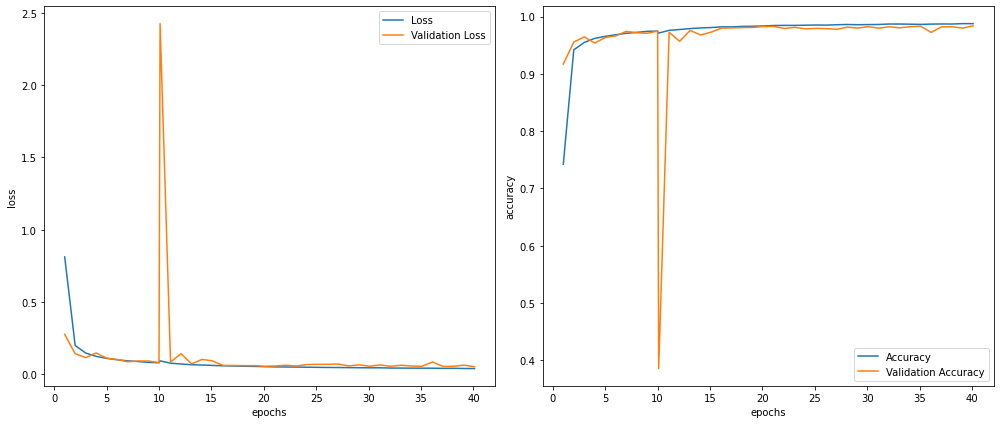

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.lineplot(x='epochs', y='loss', data=plotting, ax=axes[0], label='Loss')
sns.lineplot(x='epochs', y='val_loss', data=plotting, ax=axes[0], label='Validation Loss')
sns.lineplot(x='epochs', y='accuracy', data=plotting, ax=axes[1], label='Accuracy')
sns.lineplot(x='epochs', y='val_accuracy', data=plotting, ax=axes[1], label='Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
#ectonas.dynamic_parameters.log

In [29]:
plotting.head()

,epochs,loss,accuracy,val_loss,val_accuracy
0,1.0,0.812418,0.742133,0.276263,0.9170
1,2.0,0.199574,0.941867,0.143069,0.9554
2,3.0,0.147947,0.954717,0.116060,0.9645
3,4.0,0.124565,0.961800,0.148278,0.9538
4,5.0,0.110614,0.965367,0.112458,0.9633


In [30]:
# rolling plots for less spikey curves
df_roll = plotting.rolling(3, min_periods=1, center=False).mean()

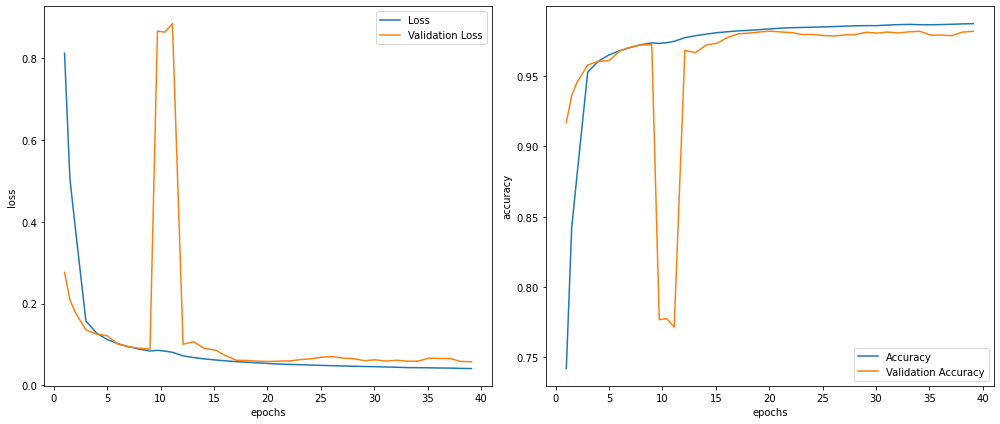

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.lineplot(x='epochs', y='loss', data=df_roll, ax=axes[0], label='Loss')
sns.lineplot(x='epochs', y='val_loss', data=df_roll, ax=axes[0], label='Validation Loss')
sns.lineplot(x='epochs', y='accuracy', data=df_roll, ax=axes[1], label='Accuracy')
sns.lineplot(x='epochs', y='val_accuracy', data=df_roll, ax=axes[1], label='Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()